In [ ]:
!pip install openpyxl
!pip install wordcloud

# Modules for data processing
import pandas as pd
import numpy as np
import os
import re
import sys
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings("ignore")

# REFERENCE: https://www.kaggle.com/dmitryuarov/eda-covid-19-impact-on-digital-learning
STATE_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'District Of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
STATE_NAME = dict([(y, x) for x, y in STATE_ABBR.items()])

# ########################################################################
# ### analyze_dataset
# ########################################################################
# #
# # Simple function to help quickly analyze information & usability of
# # a dataset. Provides information about shape, null values, unique
# # values & basic statistical features.
# #
# # Inputs:
# #   1.  df_path (string) -> Dataset path (if available)
# #   2.  df (pandas dataframe) -> Dataset (if available)
# #   3.  direct_df (boolean) -> Whether dataset path or dataset is
# #       being provided
# #   4.  processing_func (function) -> If dataset needs to be processed
# #       before analyzing
# #   5.  Other arguments for pd.read_csv(...) if dataset path is being
# #       provided
# #
# # Return:   Either dataframe itself (if path provided) or head of
# #           dataframe (if dataframe provided)
# #
# ########################################################################

# def analyze_dataset(df_path = None, df = None, direct_df = False, processing_func = lambda x: x, **read_csv_args):
    
#     if(direct_df == False):
#         df = pd.read_csv(df_path, **read_csv_args)
#     df = processing_func(df)
    
#     num_rows, num_cols = df.shape
#     dtypes = dict(df.dtypes.items())
#     print("*****************")
#     print("Basic Info:")
#     print("*****************\n")
#     print(f"Shape of Dataset: {num_rows} rows, {num_cols} cols")
#     print("Columns:")
#     for col_idx, col in enumerate(df.columns):
#         print(f"\t{col_idx+1}. {col}\n\t\t\t\t\t\t\t\t{dtypes[col]}")
    
#     print("\n\n\n*****************")
#     print("Null Values:")
#     print("*****************\n")
#     nulls = pd.isnull(df).sum()
#     print(f"Total Nulls: {nulls.sum()}")
#     nulls = nulls[nulls > 0]
#     nulls = list(sorted(nulls.items(), key = lambda x: x[1], reverse = True))
#     print("Columns with missing values:")
#     for col_idx, (col_name, col_missin_num) in enumerate(nulls):
#         print(f"\t{col_idx + 1}. {col_name}\n\t\t\t\t\t\t\t\t{col_missin_num} missing ({col_missin_num / num_rows * 100:.1f}%)")
    
#     print("\n\n\n*****************")
#     print("Column-specific:")
#     print("*****************\n")
#     print("Unique values in columns:")
#     idx = 1
#     for col in df.columns:
#         nunique = df[col].nunique()
#         if(nunique < 10):
#             unique_vals = ["'" + str(x) + "'" for x in df[col].unique()]
#             print(f"{idx}. {col} has {nunique} unique values")
#             idx += 1
#             print(f"\t[ {', '.join(unique_vals)} ]")
#     print("\n\nStatistical Features:")
#     print(df.describe())
    
#     print("\n\n")
#     if(direct_df == True):
#         return df.head()
#     else:
#         return df

########################################################################
### load_main_dataset
########################################################################
#
# Function to load the main processed & merged dataset for
# engagement. Has options to merge selected datasets. The processing
# has been done separately in another function `process_main_dataset`
#
# Inputs:
#   1.  whether_merge_district (boolean) -> Whether to merge districts
#       data
#   2.  whether_merge_products (boolean) -> Whether to merge products
#       data
#   3.  whether_merge_dates (boolean) -> Whether to merge dates data
#
# Return:   Engagement data merged with other relevant datasets
#
########################################################################

def load_main_dataset(whether_merge_districts = True, whether_merge_products = True, whether_merge_dates = True):
    def reduce_dtype_size(df):
        numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
        for numeric_col in numeric_cols:
            if('float' in str(df[numeric_col].dtype)):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
            elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
            else:
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
        return df
    
    def merge_districts_data(engagement_data):
        districts_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/districts_data.csv')
        districts_data = reduce_dtype_size(districts_data)
        merged_engagement_data = pd.merge(engagement_data, districts_data, how = 'left', on = 'district_id')
        return merged_engagement_data

    def merge_products_data(engagement_data):
        products_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/products_data.csv')
        products_data = reduce_dtype_size(products_data)
        merged_engagement_data = pd.merge(engagement_data, products_data, how = 'left', left_on = 'lp_id', right_on = 'LP ID')
        merged_engagement_data = merged_engagement_data.drop('LP ID', axis = 1)
        return merged_engagement_data

    def merge_dates_data(engagement_data):
        dates_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/dates_data.csv', parse_dates = ['date'])
        dates_data = reduce_dtype_size(dates_data)
        merged_engagement_data = pd.merge(engagement_data, dates_data, how = 'left', left_on = 'time', right_on = 'date')
        merged_engagement_data = merged_engagement_data.drop('date', axis = 1)
        return merged_engagement_data

    engagement_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/engagement_data.csv', parse_dates = ['time'])
    engagement_data = reduce_dtype_size(engagement_data)
    if(whether_merge_districts == True):
        engagement_data = merge_districts_data(engagement_data)
    if(whether_merge_products == True):
        engagement_data = merge_products_data(engagement_data)
    if(whether_merge_dates == True):
        engagement_data = merge_dates_data(engagement_data)
    
    return engagement_data


# ########################################################################
# ### process_main_dataset
# ########################################################################
# #
# # Function to process the main processed & save it for
# # loading later from another function `load_main_dataset`.
# #
# # Inputs:
# #   1.  whether_load_url_html_data (boolean) -> Whether to process
# #       and save URL's HTML data
# #
# # Return:   None
# #
# ########################################################################

# def process_main_dataset(whether_load_url_html_data = False):
#     def get_all_na_idx(df):
#         all_na_idx = df.isnull().all(axis=1)
#         return all_na_idx[all_na_idx == True].keys()

#     def add_dummys(df, dummy_cols, remove_orig_dummy_cols = False):
#         dummy_df = df[dummy_cols]
#         dummy_df = pd.get_dummies(dummy_df)
        
#         df = pd.concat([df, dummy_df], axis = 1)
#         if(remove_orig_dummy_cols == True):
#             df = df.drop(dummy_cols, axis = 1)
        
#         return df

#     def reduce_dtype_size(df):
#         numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
#         for numeric_col in numeric_cols:
#             if('float' in str(df[numeric_col].dtype)):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
#             elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
#             else:
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
#         return df
    
#     def load_districts_data():
        
#         def districts_data_preprocessing(districts_data):
            
#             def process_lower_upper_bounds(df_series):
#                 processed_lower_series = []
#                 processed_upper_series = []
                
#                 for row in df_series:                
#                     if(pd.isnull(row) == True):
#                         processed_lower_series.append(row)
#                         processed_upper_series.append(row)
#                     else:
#                         assert(len(row[1:-1].split(', ')) == 2)
#                         lower_val, upper_val = row[1:-1].split(', ')
#                         lower_val = float(lower_val)
#                         upper_val = float(upper_val)
#                         processed_lower_series.append(lower_val)
#                         processed_upper_series.append(upper_val)
                
#                 return processed_lower_series, processed_upper_series
            
#             for col in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
#                 lower_series, upper_series = process_lower_upper_bounds(districts_data[col])
#                 districts_data[col + '_lower_bound'] = pd.Series(lower_series, index = districts_data.index)
#                 districts_data[col + '_upper_bound'] = pd.Series(upper_series, index = districts_data.index)
#                 districts_data[col + '_bound_avg'] = pd.Series(np.add(lower_series, upper_series) / 2.0, index = districts_data.index)
            
#             districts_data = districts_data.drop(['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'], axis = 1)
#             return districts_data
        
#         districts_data = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
        
#         districts_data = districts_data_preprocessing(districts_data)
#         districts_data = districts_data.drop(get_all_na_idx(districts_data.drop('district_id', axis = 1))).reset_index(drop = True)
#         districts_data = add_dummys(districts_data, ['locale'], remove_orig_dummy_cols = False)
        
#         #all_states = districts_data['state'].unique()
#         #district_id_state_map = dict(districts_data[['district_id', 'state']].values)
#         #state_district_id_map = dict([(x, [y for y in district_id_state_map if district_id_state_map[y] == x]) for x in all_states])
#         #districts_data = districts_data.drop('state', axis = 1)
        
#         districts_data = reduce_dtype_size(districts_data)
#         return districts_data

#     districts_data = load_districts_data()
    
#     # URL Information Extraction
#     #   For July 2021
#     #   Using similarweb.com
#     #   Avg Duration - in seconds
#     #   Total Visits - in 1000s
#     def load_url_html_data():
#         url_html_dict = {}

#         all_html_content = ""
#         with open(f'./Data/url_info/combined_url_info_data.txt', 'r') as html_file:
#             all_html_content = html_file.read()

#         tot_num_files = len([x for x in all_html_content.split('---') if len(x.strip()) != 0])
#         print(f"Total No. of files: {tot_num_files}\n\n")

#         for html_content_idx, html_content in enumerate(all_html_content.split('---')):
            
#             html_content = html_content.strip()
#             if(len(html_content) == 0):
#                 print("ERROR: URL not found")
#                 sys.exit("")
            
#             url_name = html_content.split('<')[0].strip()
#             html_content = '<'.join(html_content.split('<')[1:])
#             print(f"{html_content_idx + 1}. File: {url_name}\n")
#             if(url_name in url_html_dict):
#                 print("ERROR: Name already exists")
#                 sys.exit("")
#             url_html_dict[url_name] = {}
            
#             # Global Rank
#             global_rank = re.findall('\"GlobalRank":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(global_rank) != 1):
#                 print("ERROR: Global Rank")
#                 print(global_rank)
#                 sys.exit("")
#             global_rank = int(global_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['global_rank'] = global_rank

#             # Country
#             if('<img class="websiteRanks-titleIconImg" src="/images/flags-svg/flag-icon-us.svg">' in html_content):
#                 country = 'USA'
#             else:
#                 print("Country: Not USA!")
#                 country = 'Not_USA'
#             url_html_dict[url_name]['country'] = country
            
#             # Country Rank
#             country_rank = re.findall('\"CountryRanks":\{"\d+":\[\d+,\d+,-?\d+,\d+\]\}', html_content)
#             if(len(country_rank) != 1):
#                 print("ERROR: Country Rank")
#                 print(country_rank)
#                 sys.exit("")
#             country_rank = int(country_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['country_rank'] = country_rank
            
#             # Category
#             category = re.findall('<a class="websiteRanks-nameText" data-analytics-category="Internal Link" data-analytics-label="Category Rank/.+" href="/top-websites/category/.+" itemprop="significantLink">.+</a>', html_content)
#             if(len(category) != 1):
#                 print("ERROR: Category")
#                 print(category)
#                 url_html_dict[url_name]['main_category'] = np.nan
#                 url_html_dict[url_name]['sub_category'] = np.nan
#             else:
#                 category = category[0].split('Category Rank/')[1].split('"')[0]
#                 main_category = category.split('/')[0]
#                 url_html_dict[url_name]['main_category'] = main_category
#                 if(len(category.split('/')) != 1):
#                     sub_category = category.split('/')[-1]
#                 else:
#                     sub_category = ""
#                 url_html_dict[url_name]['sub_category'] = sub_category

#             # Category Rank
#             category_rank = re.findall('\"CategoryRank\":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(category_rank) != 1):
#                 print("ERROR: Category Rank")
#                 print(category_rank)
#                 sys.exit("")
#             category_rank = int(category_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['category_rank'] = category_rank

#             # Total Visits
#             total_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">.*\d+[KMB]</span>', html_content)
#             if(len(total_visits) != 1):
#                 print("ERROR: Total Visits")
#                 print(total_visits)
#                 url_html_dict[url_name]['total_visits'] = np.nan
#             else:
#                 total_visits = total_visits[0].split('>')[1].split('<')[0]
#                 units = total_visits[-1]
#                 total_visits = float(''.join([x for x in total_visits if x.isdigit()]))
#                 if(units == 'K'):
#                     total_visits = total_visits * 1
#                 elif(units == 'M'):
#                     total_visits = total_visits * 1000
#                 elif(units == 'B'):
#                     total_visits = total_visits * 1000000
#                 url_html_dict[url_name]['total_visits'] = total_visits

#             # Avg Duration
#             avg_duration = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+:\d+:\d+</span>', html_content)
#             if(len(avg_duration) != 1):
#                 print("ERROR: Avg Duration")
#                 print(avg_duration)
#                 url_html_dict[url_name]['avg_duration'] = np.nan
#             else:
#                 avg_duration = avg_duration[0].split('>')[1].split('<')[0]
#                 hr_val, min_val, sec_val = avg_duration.split(':')
#                 avg_duration = 3600 * int(hr_val) + 60 * int(min_val) + int(sec_val)
#                 url_html_dict[url_name]['avg_duration'] = avg_duration

#             # Page Visits
#             page_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+\.\d+</span>', html_content)
#             if(len(page_visits) != 1):
#                 print("ERROR: Page Visits")
#                 print(page_visits)
#                 url_html_dict[url_name]['page_visits'] = np.nan
#             else:
#                 page_visits = float(page_visits[0].split('>')[1].split('<')[0])
#                 url_html_dict[url_name]['page_visits'] = page_visits

#             # Bounce Rate
#             bounce_rate = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+.\d+%</span>', html_content)
#             if(len(bounce_rate) != 1):
#                 print("ERROR: Bounce Rate")
#                 print(bounce_rate)
#                 url_html_dict[url_name]['bounce_rate'] = np.nan
#             else:
#                 bounce_rate = float(bounce_rate[0].split('>')[1].split('%')[0])
#                 url_html_dict[url_name]['bounce_rate'] = bounce_rate
            
#             # Description
#             description = re.findall('<p itemprop="description" class="websiteHeader-companyDescription js-companyDescription">.+</p>', html_content)
#             if(len(description) != 1):
#                 url_html_dict[url_name]['description'] = np.nan
#             else:
#                 description = description[0].split('>')[1].split('<')[0]
#                 url_html_dict[url_name]['description'] = description

#         url_html_df = pd.DataFrame.from_dict(url_html_dict, orient = 'index').reset_index(drop = False)
#         url_html_df.columns = ['URL'] + [*url_html_df.columns][1:]

#         url_html_df['global_rank'] = url_html_df['global_rank'].replace({0: np.nan})
#         url_html_df['country_rank'] = url_html_df['country_rank'].replace({0: np.nan})
#         url_html_df['category_rank'] = url_html_df['category_rank'].replace({0: np.nan})

#         additional_data = pd.read_csv('./Data/url_info/url_info_mobile.csv')
#         url_html_df = pd.concat([url_html_df, additional_data], axis = 0)

#         def find_subpage_level(url):
#             level = url.split('://')[1]
#             level = level.split('/')
#             level = [x for x in level if len(x.strip()) > 0]
#             return len(level) - 1
#         url_html_df['URL_subpage_level'] = url_html_df['URL'].apply(find_subpage_level)
#         url_html_df['URL_subpage_visits'] = url_html_df.apply(lambda x: x['total_visits'] * (((100 - x['bounce_rate']) / 100) ** x['URL_subpage_level']), axis = 1)
#         url_html_df['URL_page_duration'] = url_html_df['avg_duration'] / url_html_df['page_visits']
#         url_html_df['URL_subpage_total_browsing_days'] = url_html_df['URL_subpage_visits'] * url_html_df['URL_page_duration'] / 60 / 60 / 24
#         url_html_df['URL_subpage_avg_browsing_days'] = url_html_df['URL_subpage_total_browsing_days'] / 31
#         url_html_df.to_csv('./Data/url_info/final_url_data.csv', index = False)
    
#     def load_products_data():
    
#         def products_data_preprocessing(products_data):

#             products_data['Primary Category'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if pd.isna(x) == False else np.nan)
#             products_data['Primary Category'] = products_data['Primary Category'].map({'LC': 'LC', 'CM': 'CM', 'SDO': 'SDO', 'LC/CM/SDO': 'Other'})
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if pd.isna(x) == False else np.nan)
            
#             def sector_map(sectors):
                
#                 sector_prek12 = []
#                 sector_higher_ed = []
#                 sector_corporate = []
                
#                 for sector in sectors:
#                     if(pd.isna(sector) == True):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed; Corporate'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     elif(sector == 'Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(1)
#                     elif(sector == 'Higher Ed; Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     else:
#                         print(f"***\nUnknown sector detected! {sector}\n***")
                
#                 return sector_prek12, sector_higher_ed, sector_corporate
            
#             sector_prek12, sector_higher_ed, sector_corporate = sector_map(products_data['Sector(s)'])
#             products_data = products_data.assign(Sector_prek12 = sector_prek12)
#             products_data = products_data.assign(Sector_higher_ed = sector_higher_ed)
#             products_data = products_data.assign(Sector_corporate = sector_corporate)
            
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].replace({"Sites, Resources & References": "Sites, Resources & Reference"})
            
#             # Correcting small mistakes
#             products_data['URL'] = products_data['URL'].replace({'https://fligprid.com': 'https://flipgrid.com'})

#             if(whether_load_url_html_data == True):
#                 load_url_html_data()
#             url_info_data = pd.read_csv('./Data/url_info/final_url_data.csv')
#             url_info_data.columns = ['mainURL_' + x if x != 'URL' else x for x in url_info_data.columns]
#             products_data = pd.merge(products_data, url_info_data, how = 'left', on = 'URL')
            
#             products_data['mainURL_country_rank'] = products_data.apply(lambda x: x if x['mainURL_country'] == 'USA' else np.nan, axis = 1)
            
#             return products_data
        
#         products_data = pd.read_csv('./Data/learnplatform-covid19-impact-on-digital-learning/products_info.csv')
        
#         products_data = products_data_preprocessing(products_data)
#         products_data = add_dummys(products_data, ['Sector(s)', 'Primary Category', 'Primary Essential Function', 'mainURL_main_category'], remove_orig_dummy_cols = False)
        
#         products_data = reduce_dtype_size(products_data)
#         return products_data

#     products_data = load_products_data()

#     # Not focusing on vacation dates since time-analysis is not priority

#     def load_dates_data():
#         days_2020 = pd.date_range(datetime(2020, 1, 1), datetime(2020, 12, 31))
#         dates_data = pd.DataFrame.from_dict({'date': days_2020})
        
#         dates_data['month'] = dates_data['date'].apply(lambda x: x.month)
#         dates_data['day'] = dates_data['date'].apply(lambda x: x.day)
#         dates_data['day_of_week'] = dates_data['date'].apply(lambda x: calendar.day_name[x.weekday()])
#         dates_data['is_weekend'] = dates_data['day_of_week'].apply(lambda x: 1 if (x == 'Saturday') | (x == 'Sunday') else 0)
        
#         us_holidays = pd.read_csv('./Data/US Holiday Dates (2004-2021).csv', usecols = ['Date', 'Holiday'], parse_dates = ['Date'])
#         dates_data = pd.merge(dates_data, us_holidays, how = 'left', left_on = 'date', right_on = 'Date')
#         dates_data = dates_data.drop('Date', axis = 1)
#         dates_data['is_holiday'] = dates_data['Holiday'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
        
#         dates_data = add_dummys(dates_data, ['day_of_week', 'Holiday'], remove_orig_dummy_cols = False)
#         dates_data = reduce_dtype_size(dates_data)
#         return dates_data

#     dates_data = load_dates_data()

#     def load_engagement_data():

#         engagement_data = pd.DataFrame()
#         districts = []
        
#         for x in os.listdir('./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
#             data_x = pd.read_csv(f'./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/{x}', parse_dates = ['time'])
#             engagement_data = pd.concat([engagement_data, data_x], axis = 0)
#             districts.extend([int(x.split('.')[0])] * data_x.shape[0])
        
#         engagement_data['district_id'] = pd.Series(districts, index = engagement_data.index)
        
#         top_products_id = list(products_data['LP ID'].unique())
#         districts_id = list(districts_data['district_id'].unique())
#         engagement_data = engagement_data[engagement_data['lp_id'].isin(top_products_id)]
#         engagement_data = engagement_data[engagement_data['district_id'].isin(districts_id)]
        
#         same_url_map = {
#             33562: 75206,
#             87841: 35971
#         }
#         engagement_data['lp_id'] = engagement_data['lp_id'].replace(same_url_map)
#         engagement_data = engagement_data.groupby(['time', 'lp_id', 'district_id'])[['pct_access', 'engagement_index']].aggregate(np.nansum).reset_index()
        
#         engagement_data = reduce_dtype_size(engagement_data)
#         return engagement_data

#     engagement_data = load_engagement_data()

#     # # Saving all datasets
#     districts_data.to_csv('./Data/Processed_Dataset/districts_data.csv', index = False)
#     products_data.to_csv('./Data/Processed_Dataset/products_data.csv', index = False)
#     dates_data.to_csv('./Data/Processed_Dataset/dates_data.csv', index = False)
#     engagement_data.to_csv('./Data/Processed_Dataset/engagement_data.csv', index = False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

COLOR_WHITE = '#F8F1FF'
COLOR_BLACK = '#231942'
COLOR_DARK_BLUE = '#156BB7'
COLOR_LIGHT_BLUE = '#63D1DF'
COLOR_GREEN = '#30DB8D'
COLOR_DARK_GREEN = '#0DAB6C'
COLOR_ORANGE = '#FBAB60'
COLOR_YELLOW = '#F8E16C'
COLOR_RED = '#DA4167'

PLOT_THEME_LIGHT = {
    'text': COLOR_BLACK,
    'axis': COLOR_BLACK,
    'subtitle': COLOR_DARK_BLUE,
    'color+1': COLOR_DARK_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_DARK_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_LIGHT_BLUE,
    'inv': COLOR_WHITE,
    'color+1_lower': '#064B30',
    'color+1_higher': '#2EEFA2',
    'gray': '#676076',
}
PLOT_THEME_LIGHT['groups'] = [PLOT_THEME_LIGHT[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

PLOT_THEME_DARK = {
    'text': COLOR_WHITE,
    'axis': COLOR_WHITE,
    'subtitle': COLOR_LIGHT_BLUE,
    'color+1': COLOR_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_LIGHT_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_DARK_BLUE,
    'inv': COLOR_BLACK,
    'color+1_lower': '#188B57',
    'color+1_higher': '#86EABD',
    'gray': '#D6CFDB',
}
PLOT_THEME_DARK['groups'] = [PLOT_THEME_DARK[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

def create_fig(nrows = 1, ncols = 1, width = 10, height = 5):
    fig, ax = plt.subplots(nrows, ncols, figsize = (width, height))
    return fig, ax

def remove_spines(ax, theme = {}):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(theme['axis'])
    ax.spines['left'].set_color(theme['axis'])
    return ax

def remove_all_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

def set_titles_and_labels(fig, ax, fig_title = "", title = "", xlabel = "", ylabel = "", theme = {}):
    fig.suptitle(fig_title, fontsize = 30, color = theme['text'])
    ax.set_title(title, fontsize = 20, color = theme['subtitle'])
    ax.set_xlabel(xlabel, fontsize = 15, color = theme['text'])
    ax.set_ylabel(ylabel, fontsize = 15, color = theme['text'])
    return fig, ax

def set_ticks(ax, theme):
    ax.tick_params(axis = 'x', colors = theme['axis'])
    ax.tick_params(axis = 'y', colors = theme['axis'])
    return ax

def set_xticklabels(ax, labels, rotate_x = 0, theme = {}):
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, color = theme['text'], rotation = rotate_x)
    return ax

def set_yticklabels(ax, labels, rotate_y = 0, theme = {}):
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, color = theme['text'], rotation = rotate_y)
    return ax

def set_bg(fig, ax, theme):
    fig.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])
    return fig, ax

def select_theme(theme):
    if(theme == 'DARK'):
        return PLOT_THEME_DARK
    else:
        return PLOT_THEME_LIGHT

def set_legend(ax, theme):
    ax.legend(loc = 'best')
    return ax

def plot_decoration():
    return """
    fig, ax = set_bg(fig, ax, theme); ax = set_ticks(ax, theme); ax = remove_spines(ax, theme); fig, ax = set_titles_and_labels(fig, ax, suptitle, title, xlabel, ylabel, theme);
    """.strip()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lineplot(x_vals, y_vals, width = 15, height = 7, labels = [], suptitle = "Lineplot", title = "Demo", xlabel = "", ylabel = "", theme = 'DARK'):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    if(len(y_vals) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
    else:
        group_colors = theme['groups'][:len(y_vals)]
    for y_val_idx, y_val in enumerate(y_vals):
        if(len(labels) == 0):
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = f'line #{y_val_idx + 1}')
        else:
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = labels[y_val_idx])
    ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_barplot(x_names, y_vals, cats = [], width = 15, height = 7, suptitle = "Barplot", title = "Demo", xlabel = '', ylabel = '', theme = 'DARK', rotate_x = 0, rotate_y = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    x_vals = np.arange(len(x_names))
    if(len(cats) > 0):
        uniq_cats = list(sorted(pd.Series(cats).unique()))
        if(len(uniq_cats) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
        else:
            group_colors = theme['groups'][:len(uniq_cats)]
        group_colors = [group_colors[uniq_cats.index(x)] for x in cats]
    else:
        if(len(y_vals) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
        else:
            group_colors = theme['groups'][:len(y_vals)]
    ax.bar(x_vals, y_vals, color = group_colors)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_scatterplot(x_vals, y_vals, cats = [1], width = 15, height = 7, suptitle = "Scatterplot", title = 'Demo', xlabel = '', ylabel = '', theme = 'DARK', annotate = False, annotate_texts = []):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    no_cats_passed = False
    if(len(cats) == 1):
        cats = np.ones(len(x_vals))
        no_cats_passed = True
    uniq_cats = pd.Series(cats).unique()
    if(len(uniq_cats) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
    else:
        group_colors = theme['groups'][:len(uniq_cats)]
    for cat_idx, cat in enumerate(uniq_cats):
        ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    if(annotate == True):
        for idx in range(len(x_vals)):
            ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
    if(no_cats_passed == False):
        ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_us_map(state_vals_df, title, val_col, val_label, range_min_val = 0, range_max_val = 1, theme = 'DARK', state_col = 'STATE_ABBR'):
    
    theme = select_theme(theme)

    layout = dict(
        font_family = 'Source Sans Pro',
        font_color = theme['text'],
        title_text = title,
        # To change
        title_font = dict(
            family = "Source Sans Pro",
            size = 25,
            color = theme['axis']
        ),
        geo_scope = 'usa',
        paper_bgcolor = theme['bg'],
        geo_bgcolor = theme['bg'],
        geo = dict(
            landcolor = theme['inv'],
            subunitcolor = theme['gray'],
            lakecolor = theme['bg'],
        ),
    )

    fig = px.choropleth(
        state_vals_df,
        locations = state_col,
        color = val_col,
        color_continuous_scale = [theme['color-1'], theme['color+1_higher']],
        range_color = (range_min_val, range_max_val),
        locationmode = "USA-states",
        labels = {val_col : val_label, state_col: 'State'},
    )

    fig.update_layout(layout)
    fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
    fig.show()
    
DATA = load_main_dataset()

<div align='center'>
    <font size='+3' color='#75D345'>
        <b>A Day of Digital Learning</b>
    </font>
    <br>
    <font size='+2.5' color='#FBAB60'>
        <b>Part 2: Morning Mania</b>
    </font>
    <br>
    <br>
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-1-wake-up">
        <font size='+1'>
            &#9202; Wake Up!
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-2-morning-mania">
        <font size='+1'>
            <b>&#127748; Morning Mania</b>
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-3-sleepy-noons">
        <font size='+1'>
            &#127774; Sleepy Noons
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-4-finally-done">
        <font size='+1'>
            &#127769; Finally Done!
        </font>
    </a>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>9 AM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    After an hour of her Maths class, Grace felt like a prisoner on the day of release. She was confident that whatever happens next, cannot be worse than what just happened.
    <br><br>
    "<b>Science</b> class is next. I like science," she nodded with a slight smile on her face. "You should like it," I said. "After all, the most revolutionary changes on Earth in the last few hundred years have been through science & technology. Cars, vaccines, bulbs, mobiles and so on. Ah, and don't forget the internet which has connected each and every one of us together."
    <br><br>
    Suddenly, a boy started talking from Grace's laptop. "Ma'am," he said. "Adam won't be attending today's class. The internet in his area is down."
</font>
</span>
</div>

<div>
<font size='+1'>
    Alright, maybe internet has not connected 'each and every one' of us. But why? Maybe broadband is not available in some remote areas. Maybe broadband is not affordable for some. But does having unstable or no internet connectivity cost students like Adam their ability to learn digitally. Surely yes, I thought. So I explored more and this is what I found -
</font>
</div>

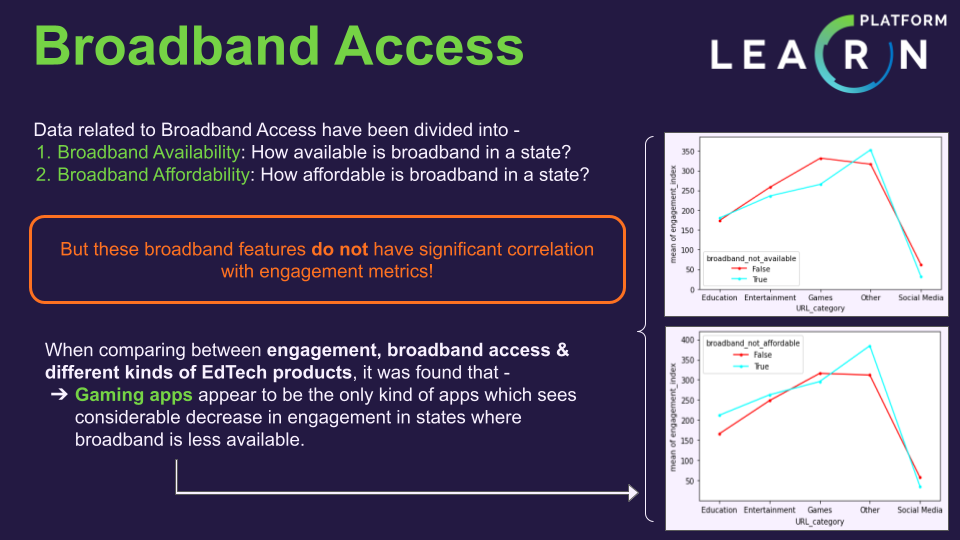

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+0.5'>
    Let's start off by collecting data about broadband access. To improve the quality of this analysis, I used three different datasets which encompass different aspects of broadband access. After going through the combined features available, I realized that almost all features indicated either how available broadband is in a state, or how affordable broadband is for the people. This is why I decided to categorize the features based on whether it explains <font color='#FD7121'>Broadband Availability</font> or <font color='#FD7121'>Braodband Affordability</font>.
    <br><br>
</font>
</div>

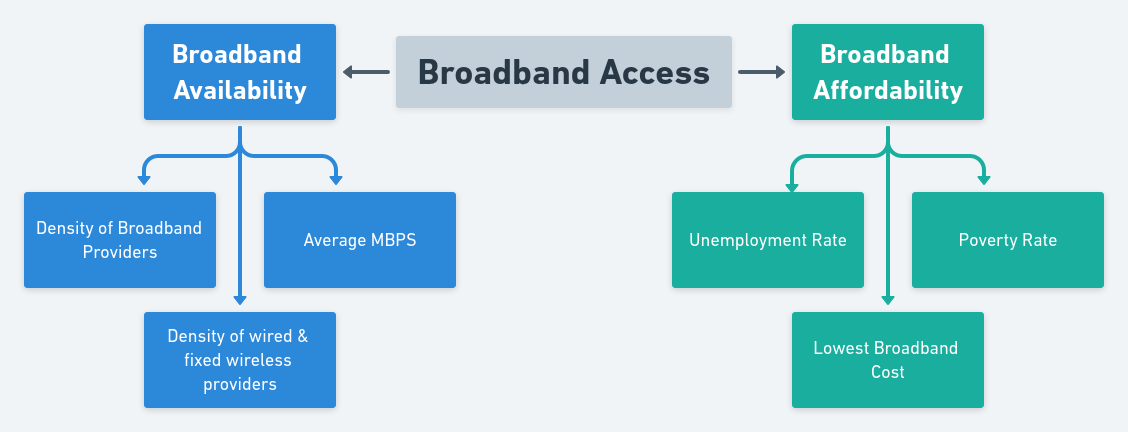

<div>
<font size='+0.5'>
    <br><br>
    Further, since there were many features for each category, I applied PCA to reduce the dimensions until the explained variance was atleast 70%. Out of these components, shown below are the weights of the <b>first PCA component</b> for each category.
    <br><br>
    <a style="background-color:#30DB8D; padding: 10px;">Green Bars</a> - Features which have high absolute weights (these features have more influence over the PCA component)
    <br><br>
    <a style="background-color:#DA4167; padding: 10px;">Red Bars</a> - Features which have relatively less absolute weights (these features do not influence the PCA component as much as others) 
    <br><br>
    The main aim of analyzing the first PCA component is to answer the question - if I had to represent all these several features under a single feature, then what exactly would that single feature majorly represent. In the case of Broadband Availability, the component increases in value with increase in density of Broadband providers; hence higher this value, more available broadband is. For Broadband Affordability features, the component decreases with poverty rate and increases with % of population having home broadband. Hence higher the value of this component for a state, higher are the chances of people in that state being able to afford broadband.
</font>
</div>

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot

from IPython.display import HTML, display
import tabulate

data1 = pd.read_csv('/kaggle/input/learnplatform-analysis-data/USBroadbandUsagePercentages_copy.csv')
data1 = data1.groupby('ST')[['BROADBAND AVAILABILITY PER FCC', 'BROADBAND USAGE']].aggregate(np.nanmean).reset_index()

data2 = pd.read_excel('/kaggle/input/learnplatform-analysis-data/publicdata_imls_metrics.xlsx', sheet_name = 'State Data REV')
data2 = data2.drop('GEO_ID', axis = 1)
data2['State_Code'] = data2['State'].map(STATE_ABBR)

data3 = pd.read_csv('/kaggle/input/learnplatform-analysis-data/broadband_data_opendatachallenge.csv')
data3 = data3.groupby('State')[[x for x in data3.columns if x not in ['Zip', 'County', 'State']]].aggregate(np.nanmean).reset_index()
data3 = data3[data3['State'] != 'Palau']
data3['State_Code'] = data3['State'].map(STATE_ABBR)

data = pd.merge(data2, data3, how = 'inner', on = 'State_Code')
data = pd.merge(data, data1, how = 'inner', left_on = 'State_Code', right_on = 'ST')
data = data.drop(['ST', 'State_x', 'State_y'], axis = 1)

us_state_area_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/us_state_area.csv', delimiter = '\t')
us_state_area_data['Sq. Mi.'] = us_state_area_data['Sq. Mi.'].apply(lambda x: int(x.replace(',', '')))
us_state_area_data = us_state_area_data.drop('Sq. Km.', axis = 1)
us_state_area_data['State and other areas'] = us_state_area_data['State and other areas'].map(STATE_ABBR)
data = pd.merge(data, us_state_area_data, how = 'inner', left_on = 'State_Code', right_on = 'State and other areas')

cols_requiring_density = [
    'Number of Broadband providers (2019)', 'WiredCount_2020', 'Fwcount_2020', 'AllProviderCount_2020',
    'Wired25_3_2020', 'Wired100_3_2020', 'All25_3_2020', 'All100_3'
]
for col in data.columns:
    if(col in cols_requiring_density):
        data[col + '_density'] = data[col] / np.log10(data['Sq. Mi.'])
data = data.drop(cols_requiring_density, axis = 1)

data = data.rename({
    'Number of Broadband providers (2019)_density': 'Number of Broadband providers',
    'Population for whom broadband available, 2019 (%)': 'Population_broadband available',
    'Percent without health insurance (2018)': 'Percent without health insurance',
    'Percent with no home computer (2018)': 'Percent with no computer',
    'Percent with no home Internet (2018)': 'Percent with no Internet',
    'Lowest broadband cost per month, 2019 ($)': 'Lowest broadband cost',
    'Lowest Priced Terrestrial Broadband Plan': 'Lowest Priced Terrestrial',
    'BROADBAND AVAILABILITY PER FCC': 'FCC_Availability'
}, axis = 1)

availability_feats = [
    'Number of Broadband providers', 'Population_broadband available',
    'WiredCount_2020_density', 'Fwcount_2020_density', 'AllProviderCount_2020_density',
    'Wired25_3_2020_density', 'Wired100_3_2020_density', 'All25_3_2020_density', 'All100_3_density',
    'AverageMbps', 'FastestAverageMbps', 'FCC_Availability'
]
affordability_feats = [
    'Unemployment rate 2019', 'Percent without health insurance', 'Poverty Rate (%)',
    'Percent received SNAP (2018)', 'Percent with no computer',
    'Percent with no Internet', 'Percent with home Broadband', 'BROADBAND USAGE',
    'Lowest broadband cost', 'Lowest Priced Terrestrial',
]

# IMPORTANT:
# Alaska not considered in analysis since the extremely large area of Alaska dominates over other features

from sklearn.decomposition import PCA

broadband_metrics_names = []
broadband_metrics = []

cats = [
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
    [1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
]
feat_names = ['Availability', 'Affordability']

for feat_idx, feats in enumerate([availability_feats, affordability_feats]):

    data_for_pca = data[data['State_Code'] != 'AK'][feats]
    for col in data_for_pca.columns:
        data_for_pca[col] = (data_for_pca[col] - data_for_pca[col].mean()) / (data_for_pca[col].std() + 0.0000000000001)

    pca = PCA(n_components = 10)
    pca_orig_data = pca.fit_transform(data_for_pca)
    for pca_idx in range(10):
        pca_data = pca.components_[pca_idx]
        expl_var = np.sum(pca.explained_variance_ratio_[:pca_idx + 1]) * 100
        if(feat_idx == 0):
            if(pca_data.sum() < 0):
                pca_data = -pca_data
                broadband_metrics.append(-pca_orig_data[:, pca_idx])
            else:
                broadband_metrics.append(pca_orig_data[:, pca_idx])
        else:
            if(pca_data.sum() > 0):
                pca_data = -pca_data
                broadband_metrics.append(-pca_orig_data[:, pca_idx])
            else:
                broadband_metrics.append(pca_orig_data[:, pca_idx])
        
        if(feat_idx == 0):
            broadband_metrics_names.append(f'availability_{pca_idx+1}')
        elif(feat_idx == 1):
            broadband_metrics_names.append(f'affordability_{pca_idx+1}')

        if(pca_idx == 0):
            plot_barplot(
                [x for x in feats], pca_data, cats = cats[feat_idx],
                width = 15, height = 7,
                suptitle = f"Broadband {feat_names[feat_idx]}", title = f"PCA Component {pca_idx + 1}, Explained Variance = {expl_var:.2f}%",
                xlabel = "Features", ylabel = "PCA Weights",
                rotate_x = 60,
                theme = 'DARK',
            )

    #     sns.heatmap(pd.DataFrame(data_for_pca).corr())
    #     plt.show()
    
        if(expl_var >= 70):
            break

<div>
<font size='+0.5'>
    Now that we have developed a metric which represents how available & affordable broadband is, it might be a good idea to apply these metrics on the US map.
    <br><br>
    As can be seen, Delaware seems to be the state with most available broadband relative to its size while states like Missouri have much less availability of Broadband connections. When it comes to affordability, Nevada seems to have the most population who can easily afford broadband while people in states like Minnesota find it difficult to afford broadband.
</font>
</div>

In [ ]:
broadband_metrics = pd.DataFrame(np.asarray(broadband_metrics).transpose(), columns = broadband_metrics_names)
#print(data.shape, social_vulnerability_metrics.shape)
broadband_data = pd.concat([data[['State_Code']], broadband_metrics], axis = 1)
broadband_data = broadband_data.groupby('State_Code')[broadband_metrics_names].aggregate(np.nanmean).reset_index(drop = False)

plot_us_map(broadband_data, "Broadband Availability - Statewise View", "availability_1", "PCA Component 1", -10, 10, state_col = 'State_Code', theme = 'DARK')
plot_us_map(broadband_data, "Broadband Affordability - Statewise View", "affordability_1", "PCA Component 1", -10, 10, state_col = 'State_Code', theme = 'DARK')

<div>
<font size='+0.5'>
    However, these broadband metrics <font color='#FD7121'>do not seem to have a significant correlation</font> with the two provided engagement metrics - pct_access & engagement_index. This comes as a bit of a surprise since one would expect more challenges in areas having less available/affordable broadband access and hence lesser engagement. But it appears students from such areas are still managing to keep up sufficiently good engagement levels.
</font>
</div>

In [ ]:
engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)
broadband_engagement_data = pd.merge(engagement_data, broadband_data, how = 'inner', left_on = 'state', right_on = 'State_Code')
target_cols = ['pct_access', 'engagement_index']
corrs = np.zeros((len(broadband_metrics_names), len(target_cols)))
corrs_pval = np.zeros((len(broadband_metrics_names), len(target_cols)))
for col_idx, col in enumerate(broadband_metrics_names):
    for target_col_idx, target_col in enumerate(target_cols):
        corrs[col_idx, target_col_idx], corrs_pval[col_idx, target_col_idx] = pearsonr(broadband_engagement_data[target_cols[target_col_idx]], broadband_engagement_data[broadband_metrics_names[col_idx]])

table = [
    ['FEATURE', 'CORRELATION WITH PCT_ACCESS', 'CORRELATION WITH ENGAGEMENT_INDEX']
]
for col_idx, col in enumerate(broadband_metrics_names):
    table_row = []
    table_row.append(f"{col.split('_')[0]} (PCA-{col.split('_')[1]})")
    table_row.append(f"{corrs[col_idx][0]:.2f} (pval = {corrs_pval[col_idx][0]:.2f})")
    table_row.append(f"{corrs[col_idx][1]:.2f} (pval = {corrs_pval[col_idx][1]:.2f})")
    table.append(table_row)

display(HTML(tabulate.tabulate(table, tablefmt='html')))        

for row_idx in range(corrs.shape[0]):
    for col_idx in range(corrs.shape[1]):
        if(corrs_pval[row_idx, col_idx] < 0.05):
            print(broadband_metrics_names[row_idx])
            print(target_cols[col_idx])
            print(corrs[row_idx, col_idx])
            print(corrs_pval[row_idx, col_idx])
            print()
#corr_check_cols = ['E_UNEMP', 'EPL_UNEMP', 'F_POV', 'F_PCI', 'F_NOHSDP', 'F_THEME1']
corr_check_cols = availability_feats
grouped_data = data.groupby('State_Code')[corr_check_cols].aggregate(np.nanmean).reset_index(drop = False)
data2 = pd.merge(engagement_data, grouped_data, how = 'inner', left_on = 'state', right_on = 'State_Code')
for col in corr_check_cols:
    pearson_corr = pearsonr(data2['pct_access'], data2[col])
    #print(col, pearson_corr)
    if(pearson_corr[1] < 0.05):
        print(col, pearson_corr)
for col in corr_check_cols:
    pearsonr_corr = pearsonr(data2['engagement_index'], data2[col])
    #print(col, pearson_corr)
    if(pearson_corr[1] < 0.05):
        print(col, pearson_corr)
#corr_check_cols = ['E_UNEMP', 'EPL_UNEMP', 'F_POV', 'F_PCI', 'F_NOHSDP', 'F_THEME1']
corr_check_cols = affordability_feats
grouped_data = data.groupby('State_Code')[corr_check_cols].aggregate(np.nanmean).reset_index(drop = False)
data2 = pd.merge(engagement_data, grouped_data, how = 'inner', left_on = 'state', right_on = 'State_Code')
for col in corr_check_cols:
    pearson_corr = pearsonr(data2['pct_access'], data2[col])
    #print(col, pearson_corr)
    if(pearson_corr[1] < 0.05):
        print(col, pearson_corr)
for col in corr_check_cols:
    pearsonr_corr = pearsonr(data2['engagement_index'], data2[col])
    #print(col, pearson_corr)
    if(pearson_corr[1] < 0.05):
        print(col, pearson_corr)

<div>
<font size='+0.5'>
    In a bid to explore further the relationship between broadband access & engagement, I decided to involve a third variable - the type of educational app. The main intention here was to see whether certain kinds of educational apps are being used less in regions where broadband is an issue. To do this, I used the two-factor ANOVA test, where interactions between broadband access & type of educational app can also be explored against engagement.
    <br><br>
    <b>NOTE: The category of EdTech apps (Education, Entertainment, Games, Others & Social Media) is a new feature that I have created. More information about these new categories of EdTech apps will be explained in the next sections.</b>
    <br><br>
    Ultimately, the p-value suggested that the broadband access - educational app interaction was not significant. However, when taking a look at the interaction plot, an interesting observation was made. <font color='#FD7121'>Gaming apps</font> seemed to be the only kind of educational apps where engagement decreased with broadband access. Another confusing aspect of the plot was that most EdTech apps (apart from gaming) seemed to have more engagement in regions with lesser broadband access. This obviously goes against common logic. Perhaps the reason why this is happening is because we are analyzing at a state-level which could be generalizing the observations. Perhaps at the county-level, the overall accuracy of these analyses might increase.
</font>
</div>

In [ ]:
engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)

def select_website_categories(x):
    if(x['mainURL_main_category'] == 'science-and-education'):
        return 'Education'
    elif(x['mainURL_main_category'] == 'arts-and-entertainment'):
        return 'Entertainment'
    elif(x['mainURL_sub_category'] == 'social-networks-and-online-communities'):
        return 'Social Media'
    elif(x['mainURL_main_category'] == 'games'):
        return 'Games'
    else:
        return 'Other'

engagement_data = pd.DataFrame()
for state in DATA['state'].unique():
    engagement_state_data = DATA[DATA['state'] == state][['state', 'mainURL_main_category', 'mainURL_sub_category', 'pct_access', 'engagement_index']]
    engagement_state_data['URL_category'] = engagement_state_data.apply(select_website_categories, axis = 1)
    engagement_state_data = engagement_state_data.groupby(['state', 'URL_category'])[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
    engagement_state_data['state'] = engagement_state_data['state'].replace(STATE_ABBR)
    engagement_data = pd.concat([engagement_data, engagement_state_data], axis = 0)

broadband_engagement_data = pd.merge(engagement_data, broadband_data, how = 'inner', left_on = 'state', right_on = 'State_Code')
broadband_engagement_data['broadband_not_available'] = (broadband_engagement_data['availability_1'] < -1.5)

fig, ax = plt.subplots(2, 2, figsize = (20, 10))

model = ols('engagement_index ~ C(URL_category)*C(broadband_not_available)', broadband_engagement_data).fit()
# print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
res = sm.stats.anova_lm(model, typ= 2)
#display(res)

ax[0][0] = interaction_plot(x=broadband_engagement_data['URL_category'], trace=broadband_engagement_data['broadband_not_available'], response=broadband_engagement_data['engagement_index'], ax = ax[0][0], colors = [COLOR_DARK_BLUE, COLOR_GREEN])

model = ols('pct_access ~ C(URL_category)*C(broadband_not_available)', broadband_engagement_data).fit()
# print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
res = sm.stats.anova_lm(model, typ= 2)
#display(res)

ax[1][0] = interaction_plot(x=broadband_engagement_data['URL_category'], trace=broadband_engagement_data['broadband_not_available'], response=broadband_engagement_data['pct_access'], ax = ax[1][0], colors = [COLOR_DARK_BLUE, COLOR_GREEN])

broadband_engagement_data['broadband_not_affordable'] = (broadband_engagement_data['affordability_1'] < -1.5)
broadband_engagement_data.head()

model = ols('engagement_index ~ C(URL_category)*C(broadband_not_affordable)', broadband_engagement_data).fit()
# print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
res = sm.stats.anova_lm(model, typ= 2)
# display(res)

ax[0][1] = interaction_plot(x=broadband_engagement_data['URL_category'], trace=broadband_engagement_data['broadband_not_affordable'], response=broadband_engagement_data['engagement_index'], ax = ax[0][1], colors = [COLOR_DARK_BLUE, COLOR_GREEN])

model = ols('pct_access ~ C(URL_category)*C(broadband_not_affordable)', broadband_engagement_data).fit()
# print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
res = sm.stats.anova_lm(model, typ= 2)
# display(res)

ax[1][1] = interaction_plot(x=broadband_engagement_data['URL_category'], trace=broadband_engagement_data['broadband_not_affordable'], response=broadband_engagement_data['pct_access'], ax = ax[1][1], colors = [COLOR_DARK_BLUE, COLOR_GREEN])

ax[0][0].axes[0].set_xlabel("")
ax[0][1].axes[1].set_xlabel("")
ax[1][0].axes[2].set_xlabel("")
ax[1][1].axes[3].set_xlabel("")
fig.suptitle("Engagement vs. Broadband Access (for different kinds of EdTech apps)", fontsize = 15)
plt.show()

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>10 AM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    It is 10 AM. Grace should be starting with her <b>Computer Science</b> class now, but her teacher allows the students a ten-minute break.
    <br><br>
    Usually around this time, Grace would also start getting bored at looking at the laptop screen. "Would you get bored after two classes if you were at school?" I asked. "Never, I would have friends to spend my time with. If classes seem long, our chit-chatting would also be long," she replied, gleaming as she remembered those moments. "But I can't do that in these online meetings."
    <br><br>
    "You should be thankful that these online meetings exist in the first place. Even while all of your friends are sitting in different parts of the city, you all can still get the same education," I said.
</font>
</span>
</div>

<div>
<font size='+1'>
    It is true that online meetings do not have the 'human touch' that Grace misses so much; but to be honest, if this pandemic would have hit us maybe a 100 years ago, continuing education would have been much more challenging in the absence of such advanced technology.
    <br><br>
    But this got me wondering, Grace has so many online tools available for her study - meetings, videos, e-books, exam portals and others. How does student engagement compare to that? Do certain kinds of EdTech products boast a better engagement metric than others? After exploring this question, here is what I found -
</font>
</div>

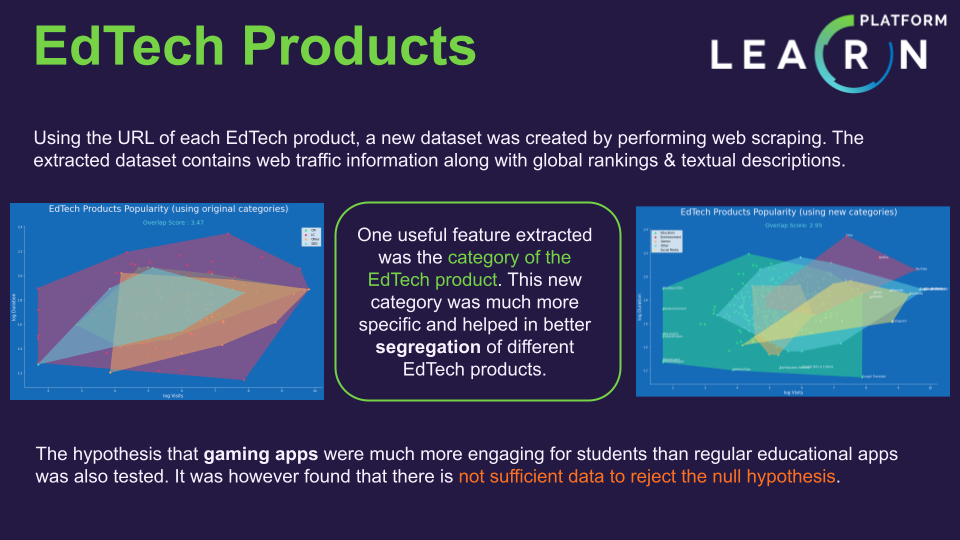

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    The first step for me would be to categorize the large number of EdTech products that I have data for. But while going through the products, I identified several well-known apps like YouTube, Facebook, Instagram. Though not technically an educational app, my first intuition was that since these products are extremely popular, they might naturally be used more. This would indeed create a bias based on the popularity of the product.
    <br><br>
    Hence, I decided to first try and quantify the popularity of each and every product. To do this, I had to create a new dataset myself by web crawling using the <a href='similarweb.com'>similarweb.com</a> site. This site provides several web traffic related statistics (like total visits, avg visit duration, bounce rate, number of pages, global ranks, etc.) which can help in determining how popular a website is.
    <br><br>
    So after several hours of hardwork (and after many hacks to prevent myself from being identified as a bot), this is what I found -
</font>
</div>

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import sys

import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from scipy import stats
from statsmodels.stats import weightstats as stests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.spatial import Delaunay

from wordcloud import WordCloud, STOPWORDS

products_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/products_data.csv')

def check_inside_polygon(x, y, labels):
    keep_idx = []
    for idx in range(len(x)):
        if(np.isnan(x[idx]) == False and np.isnan(y[idx]) == False):
            keep_idx.append(idx)
    non_na_x = x[keep_idx]
    non_na_y = y[keep_idx]
    non_na_labels = labels[keep_idx]
    convex_hulls = []
    uniq_labels = list(pd.Series(labels).unique())
    for label in uniq_labels:
        cat_x = non_na_x[non_na_labels == label]
        cat_y = non_na_y[non_na_labels == label]
        p = np.c_[cat_x, cat_y]
        convex_hulls.append(Delaunay(p))
    num_clusters = 0
    for idx in range(len(non_na_x)):
        for hull in convex_hulls:
            num_clusters += (hull.find_simplex([non_na_x[idx], non_na_y[idx]]) != -1)
    return num_clusters / len(non_na_x)

# plot_scatterplot(
#     np.log10(products_data['mainURL_URL_subpage_visits'].values),
#     np.log10(products_data['mainURL_URL_page_duration'].values),
#     width = 18, height = 10,
#     cats = products_data['Primary Category'].fillna('Other').values,
#     suptitle = 'EdTech Products Popularity (using given categories)', title = "Poor segregation", xlabel = "Visits", ylabel = "Duration",
#     annotate = False, annotate_texts = products_data['Product Name'].values,
#     theme = 'DARK'
# )

x_vals = np.log10(products_data['mainURL_URL_subpage_visits'].values)
y_vals = np.log10(products_data['mainURL_URL_page_duration'].values)
cats = [1]
width = 18
height = 10
suptitle = "EdTech Products Popularity"
title = '(Based on stats crawled from similarweb.com)'
xlabel = 'log (Monthly Visits)'
ylabel = 'log (Visit Duration in seconds)'
theme = 'DARK'
annotate = False
annotate_texts = []

annotate = True
annotate_texts = products_data['Product Name'].values.copy()
for idx in range(len(annotate_texts)):
    if((x_vals[idx] >= 2.5) & (x_vals[idx] <= 8) & (y_vals[idx] <= 2.2) & (y_vals[idx] >= 1.25)):
        annotate_texts[idx] = ''

theme = select_theme(theme)
fig, ax = create_fig(1, 1, width, height)
no_cats_passed = False
if(len(cats) == 1):
    cats = np.ones(len(x_vals))
    no_cats_passed = True
uniq_cats = pd.Series(cats).unique()
if(len(uniq_cats) > len(theme['groups'])):
    group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
else:
    group_colors = theme['groups'][:len(uniq_cats)]
for cat_idx, cat in enumerate(uniq_cats):
    ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
if(annotate == True):
    for idx in range(len(x_vals)):
        ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
if(no_cats_passed == False):
    ax = set_legend(ax, theme)
exec(plot_decoration())

plt.show()

<div>
<font size='+1'>
    Naturally, products like YouTube, Facebook & Netflix have much better popularity than other Educational apps. And frankly that is because these are not Educational apps but more of Entertainment apps. Therefore, I wanted to segregate such apps from the genuine Educational apps.
    <br><br>
    In the provided dataset, the products have been categorized into Learning & Curriculum (LC), Classroom Management (CM) & School and District Operations (SDO). But when using these categories, the segregation is extremely poor as shown below. All categories tend to overlap onto each other.
    <br><br>
    To measure this overlap, I define a metric called <b>Overlap Score</b> which calculates how many groups/clusters a point is within (on average). In the ideal case, this score should be 1 indicating that there is absolutely no overlap between clusters. In the below case, a point is expected to be in almost 3.5 clusters on average, which is high.
</font>
</div>

In [ ]:
# plot_scatterplot(
#     np.log10(products_data['mainURL_URL_subpage_visits'].values),
#     np.log10(products_data['mainURL_URL_page_duration'].values),
#     width = 18, height = 10,
#     cats = products_data['Primary Category'].fillna('Other').values,
#     suptitle = 'EdTech Products Popularity (using given categories)', title = "Poor segregation", xlabel = "Visits", ylabel = "Duration",
#     annotate = False, annotate_texts = products_data['Product Name'].values,
#     theme = 'DARK'
# )

x_vals = np.log10(products_data['mainURL_URL_subpage_visits'].values)
y_vals = np.log10(products_data['mainURL_URL_page_duration'].values)
cats = products_data['Primary Category'].fillna('Other').values
width = 18
height = 10
suptitle = "EdTech Products Popularity (using provided categories)"
xlabel = 'log (Monthly Visits)'
ylabel = 'log (Visit Duration in seconds)'
theme = 'DARK'
annotate = False
annotate_texts = []

title = f"Overlap Score: {check_inside_polygon(x_vals, y_vals, cats):.2f}"

# https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot
def encircle(x,y, ax, **kw):
    keep_idx = []
    for idx in range(len(x)):
        if(np.isnan(x[idx]) == False and np.isnan(y[idx]) == False):
            keep_idx.append(idx)
    x = x[keep_idx]
    y = y[keep_idx]
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

theme = select_theme(theme)
fig, ax = create_fig(1, 1, width, height)
no_cats_passed = False
if(len(cats) == 1):
    cats = np.ones(len(x_vals))
    no_cats_passed = True
uniq_cats = list(sorted(pd.Series(cats).unique()))
if(len(uniq_cats) > len(theme['groups'])):
    group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
else:
    group_colors = theme['groups'][:len(uniq_cats)]
for cat_idx, cat in enumerate(uniq_cats):
    ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    encircle(x_vals[cats == cat], y_vals[cats == cat], ax = ax, ec = group_colors[cat_idx], fc = group_colors[cat_idx], alpha = 0.5)
if(annotate == True):
    for idx in range(len(x_vals)):
        ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
if(no_cats_passed == False):
    ax = set_legend(ax, theme)
exec(plot_decoration())

plt.show()

<div>
<font size='+1'>
    I then decided to use the categories which were available on similarweb.com itself. I chose the Education, Entertainment, Games, Social Media & Other categories. These categories provided a lower overlap score of 3 and these clusters visually also look better segregated than before.
    <br><br>
    In addition, one can clearly see that Entertainment & Social Media apps are much more popular than Educational apps. This is the reason I will continue with these categories for future analysis.
</font>
</div>

In [ ]:
def select_website_categories(x):
    if(x['mainURL_main_category'] == 'science-and-education'):
        return 'Education'
    elif(x['mainURL_main_category'] == 'arts-and-entertainment'):
        return 'Entertainment'
    elif(x['mainURL_sub_category'] == 'social-networks-and-online-communities'):
        return 'Social Media'
    elif(x['mainURL_main_category'] == 'games'):
        return 'Games'
    else:
        return 'Other'
cats = products_data.apply(select_website_categories, axis = 1)

# plot_scatterplot(
#     np.log10(products_data['mainURL_URL_subpage_visits'].values),
#     np.log10(products_data['mainURL_URL_page_duration'].values),
#     width = 18, height = 18,
#     cats = cats.fillna('Other').values,
#     suptitle = 'EdTech Products Popularity (using newly extracted categories)', title = "Much better segregation", xlabel = "Visits", ylabel = "Duration",
#     annotate = False, annotate_texts = products_data['Product Name'].values,
#     theme = 'DARK'
# )

x_vals = np.log10(products_data['mainURL_URL_subpage_visits'].values)
y_vals = np.log10(products_data['mainURL_URL_page_duration'].values)
cats = cats.fillna('Other').values
width = 18
height = 10
suptitle = "EdTech Products Popularity (using new categories)"
title = ''
xlabel = 'log (Monthly Visits)'
ylabel = 'log (Visit Duration in seconds)'
theme = 'DARK'
annotate = False
annotate_texts = []

title = f"Overlap Score: {check_inside_polygon(x_vals, y_vals, cats):.2f}"

# https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot
def encircle(x,y, ax, **kw):
    keep_idx = []
    for idx in range(len(x)):
        if(np.isnan(x[idx]) == False and np.isnan(y[idx]) == False):
            keep_idx.append(idx)
    x = x[keep_idx]
    y = y[keep_idx]
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

annotate = True
annotate_texts = products_data['Product Name'].values.copy()
for idx in range(len(annotate_texts)):
    if((x_vals[idx] >= 2.5) & (x_vals[idx] <= 8) & (y_vals[idx] <= 2.2) & (y_vals[idx] >= 1.25)):
        annotate_texts[idx] = ''

theme = select_theme(theme)
fig, ax = create_fig(1, 1, width, height)
no_cats_passed = False
if(len(cats) == 1):
    cats = np.ones(len(x_vals))
    no_cats_passed = True
uniq_cats = list(sorted(pd.Series(cats).unique()))
if(len(uniq_cats) > len(theme['groups'])):
    group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
else:
    group_colors = theme['groups'][:len(uniq_cats)]
for cat_idx, cat in enumerate(uniq_cats):
    ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    encircle(x_vals[cats == cat], y_vals[cats == cat], ax = ax, ec = group_colors[cat_idx], fc = group_colors[cat_idx], alpha = 0.5)
if(annotate == True):
    for idx in range(len(x_vals)):
        ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
if(no_cats_passed == False):
    ax = set_legend(ax, theme)
exec(plot_decoration())
plt.show()

<div>
<font size='+1'>
    Finally, coming back to the original question, do these popular websites naturally have more student engagement? To answer this, we need a <b>Popularity Metric</b> & Engagement Metric. We already have engagement_index as a good candidate to represent student engagement. For popularity, I decided to use the following metric - (Total visits x Avg Visit Duration).
    <br><br>
    <b>NOTE: The total visits & visit duration have actually only been given for main webpages (eg. - abc.com/) but not subpages (eg. abc.com/xyz/). However, we know the average number of pages visited on the website & also how many users do not check out the subpages (bounce rate), hence the total visits & visit duration can be approximated for subpages using this formula.</b>
    <br><br>
    Popularity Index = Page Visits x Page Visit Duration
    <br>
    Page Visits = Total Visits x (100% - Bounce Rate) ^ (Subpage Depth: How many '/' are present in subpage URL)
    <br>
    Page Visit Duration = Total Visit Duration / Avg number of pages visited
    <br><br>
    Using the Popularity & Engagement metric, I plotted a scatterplot. In this plot, apps can be classified as -
    <ul>
        <li><font color='#FD7121'><b>Live up to the reputation</b></font> - Highly popular & highly used by students (YouTube, Google Classroom, Google Forms)</li>
        <li><font color='#FD7121'><b>Underperformers</b></font> - Highly popular but less used by students (Google Chrome, Google Books)</li>
        <li><font color='#FD7121'><b>Dark Horses</b></font> - Less popular but highly used by students (Kahoot!, Canvas, ST Math)</li>
        <li><font color='#FD7121'><b>Unknown & Unused</b></font> - Less popular & less used by students</li>
    </ul>
</font>
</div>

In [ ]:
products_data['popularity_index'] = products_data.apply(lambda x: np.log10(x['mainURL_URL_subpage_visits']) + np.log10(x['mainURL_URL_page_duration']), axis = 1)
product_engagement = DATA.groupby('lp_id')['engagement_index'].aggregate(np.nanmean).reset_index()
product_engagement_popularity = pd.merge(product_engagement.dropna(), products_data[['LP ID', 'Product Name', 'popularity_index', 'mainURL_main_category', 'mainURL_sub_category']].dropna(), how = 'inner', left_on = 'lp_id', right_on = 'LP ID')
product_engagement_popularity['engagement_to_popularity_ratio'] = product_engagement_popularity['engagement_index'] / product_engagement_popularity['popularity_index']

cats = product_engagement_popularity.apply(select_website_categories, axis = 1)

x_vals = np.log10(product_engagement_popularity['engagement_index'].values)
y_vals = product_engagement_popularity['popularity_index'].values
cats = cats
width = 15
height = 15
suptitle = "Engagement vs. Popularity"
title = ""
xlabel = "log (Engagement Index)"
ylabel = "log (Popularity Index)"
annotate = True
annotate_texts = product_engagement_popularity['Product Name'].values
theme = 'DARK'

annotate = True
annotate_texts = product_engagement_popularity['Product Name'].values.copy()
for idx in range(len(annotate_texts)):
    # Live up to the reputation
    if((x_vals[idx] > 1.5) & (y_vals[idx] > 7)):
        if(5 * x_vals[idx] + 2.5 * y_vals[idx] <= 37.5):
            annotate_texts[idx] = ''
    # Dark Horses
    elif((x_vals[idx] > 1.5) & (y_vals[idx] < 7)):
        if(5 * x_vals[idx] - 2.5 * y_vals[idx] <= -1):
            annotate_texts[idx] = ''
    # Underperformers
    elif((x_vals[idx] < 1.5) & (y_vals[idx] > 7)):
        if(5 * x_vals[idx] - 2.5 * y_vals[idx] >= -24):
            annotate_texts[idx] = ''
    # Flops
    else:
        if(5 * x_vals[idx] + 2.5 * y_vals[idx] >= 12):
            annotate_texts[idx] = ''

theme = select_theme(theme)
fig, ax = create_fig(1, 1, width, height)
no_cats_passed = False
if(len(cats) == 1):
    cats = np.ones(len(x_vals))
    no_cats_passed = True
uniq_cats = list(sorted(pd.Series(cats).unique()))
if(len(uniq_cats) > len(theme['groups'])):
    group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
else:
    group_colors = theme['groups'][:len(uniq_cats)]
for cat_idx, cat in enumerate(uniq_cats):
    ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
if(annotate == True):
    for idx in range(len(x_vals)):
        ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
if(no_cats_passed == False):
    #ax = set_legend(ax, theme)
    ax.legend(loc = 'upper left')
exec(plot_decoration())

ax.axhline(7, color = 'white', lw = 1)
ax.axvline(1.5, color = 'white', lw = 1)

t1 = ax.text(1.75, 7.5, "    Live up to\nthe Reputation", fontsize = 20, color = COLOR_WHITE)
t1.set_bbox(dict(facecolor=COLOR_ORANGE, alpha=0.75, edgecolor=COLOR_BLACK))

t2 = ax.text(0.35, 7.5, "    Under\nperformers", fontsize = 20, color = COLOR_WHITE)
t2.set_bbox(dict(facecolor=COLOR_ORANGE, alpha=0.75, edgecolor=COLOR_BLACK))

t3 = ax.text(1.75, 6, "  Dark\nHorses", fontsize = 20, color = COLOR_WHITE)
t3.set_bbox(dict(facecolor=COLOR_ORANGE, alpha=0.75, edgecolor=COLOR_BLACK))

t4 = ax.text(0.35, 6, "Unknown &\n   Unused", fontsize = 20, color = COLOR_WHITE)
t4.set_bbox(dict(facecolor=COLOR_ORANGE, alpha=0.75, edgecolor=COLOR_BLACK))

plt.show()

<div>
<font size='+1'>
    <b>HYPOTHESIS: Gaming apps have better engagement than regular Educational apps</b>
    <br>
    Null Hypothesis: Gaming apps & Educational apps have the same student engagement
    <br><br>
    To test this hypothesis, I used the Tukey test and found that there is no significant difference between Gaming apps & Educational apps. Hence we cannot reject the Null Hypothesis. 
</font>
</div>

In [ ]:
cats = product_engagement_popularity.apply(select_website_categories, axis = 1)
product_engagement_popularity['engagement_index'] = product_engagement_popularity['engagement_index'].apply(np.log10)
product_engagement_popularity['URL_category'] = cats

res2 = pairwise_tukeyhsd(product_engagement_popularity['engagement_index'], product_engagement_popularity['URL_category'])
print(res2.summary())
res2.plot_simultaneous('Games')
plt.show()

# res2 = pairwise_tukeyhsd(product_engagement_popularity['popularity_index'], product_engagement_popularity['URL_category'])
# print(res2.summary())
# res2.plot_simultaneous('Games')
# plt.show()

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>11 AM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    With the lunch break arriving in an hour, Grace was eager for her <b>English</b> class to end. "I know English. I am speaking to you in English. There is no need for me to learn more English," she complained to me.
    <br><br>
    "You know very basic English, Grace. You need to learn more about English so that one day you can stop asking me what each long word means in a newspaper," I scolded. "And then you need to be able to put all of those long words together and understand the meaning of that news report."
</font>
</span>
</div>

<div>
<font size='+1'>
    Grace never had a problem with speaking English. But some of her friends who were non-English speakers do face a lot of difficulty, even in regular conversation. Firstly identifying all the words, then understanding the meaning of each word and then finally putting all the words together to understand the meaning of a sentence - it was tough for them.
    <br><br>
    Right then I suddenly remembered a Natural Language Processing project that I had worked on a couple of years ago. Just to make sure a machine understands a sentence properly, researchers have spent countless hours, incredible effort and humongous bundles of cash.
    <br><br>
    I have neither of the three, so why don't I myself make sense of the textual descriptions of the different EdTech products. Maybe there exists some collective meaning within the bunch of words. When I tried that, this is what I found -
</font>
</div>

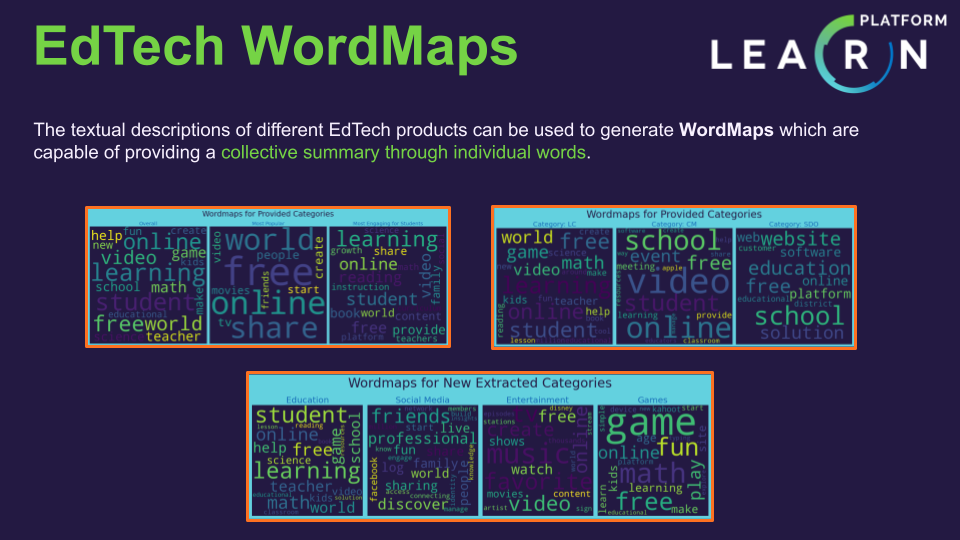

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    The wordmaps present a fun way to understand more about the EdTech products. Using the description queried from similarweb.com, I made wordmaps to know more about different kind of EdTech products. Here are a few fun short summaries (almost purely from the wordmaps) -
    <ul>
        <li>EdTech products (overall): <b>Free online learning for students</b></li>
        <li>EdTech products (most popular): <b>Sharing + creating + movies, TV & shows</b></li>
        <li>EdTech products (most engaging): <b>Learning through reading, books, instructions & videos</b></li>
    </ul>
</font>
</div>

In [ ]:
product_categories_popularity = pd.merge(product_engagement.dropna(), products_data[['LP ID', 'Product Name', 'popularity_index', 'mainURL_main_category', 'mainURL_sub_category', 'mainURL_description']].dropna(), how = 'inner', left_on = 'lp_id', right_on = 'LP ID')

suptitle = "Wordmaps for Provided Categories"

theme = select_theme('LIGHT')
fig, axs = create_fig(1, 3, 20, 8)

descriptions = ''
for description in products_data['mainURL_description'].dropna().values:
    descriptions += f" {description} "
descriptions = re.sub('amp', 'and', descriptions)
descriptions = descriptions.lower().strip()
descriptions = re.sub("[^a-z ]", "", descriptions)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width = 800, height = 800,
    background_color = COLOR_BLACK,
    stopwords = stopwords,
    min_font_size = 50
).generate(descriptions)
axs[0].imshow(wordcloud)
axs[0].set_title(f"Overall", color = theme['subtitle'], fontsize = 20)

descriptions = ''
for description in product_categories_popularity.sort_values('popularity_index', ascending = False).iloc[:25]['mainURL_description'].dropna().values:
    descriptions += f" {description} "
descriptions = re.sub('amp', 'and', descriptions)
descriptions = descriptions.lower().strip()
descriptions = re.sub("[^a-z ]", "", descriptions)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width = 800, height = 800,
    background_color = COLOR_BLACK,
    stopwords = stopwords,
    min_font_size = 50
).generate(descriptions)
axs[1].imshow(wordcloud)
axs[1].set_title(f"Most Popular", color = theme['subtitle'], fontsize = 20)

descriptions = ''
for description in product_categories_popularity.sort_values('engagement_index', ascending = False).iloc[:25]['mainURL_description'].dropna().values:
    descriptions += f" {description} "
descriptions = re.sub('amp', 'and', descriptions)
descriptions = descriptions.lower().strip()
descriptions = re.sub("[^a-z ]", "", descriptions)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    width = 800, height = 800,
    background_color = COLOR_BLACK,
    stopwords = stopwords,
    min_font_size = 50
).generate(descriptions)
axs[2].imshow(wordcloud)
axs[2].set_title(f"Most Engaging for Students", color = theme['subtitle'], fontsize = 20)

for ax in axs.flatten():
    #fig, ax = set_bg(fig, ax, theme)
    ax = set_ticks(ax, theme)
    ax = remove_all_spines(ax)
    fig.suptitle(suptitle, fontsize = 30, color = theme['text'])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(h_pad = 5)
plt.show()

<div>
<font size='+1'>
    Wordmaps have also been made for different categories of EdTech products, which could be used as a fun way to learn more about the characteristics of each category.
</font>
</div>

In [ ]:
suptitle = "Wordmaps for Provided Categories"

theme = select_theme('LIGHT')
fig, axs = create_fig(1, 3, 15, 6)
for cat_idx, cat in enumerate(products_data['Primary Category'].replace({'Other': np.nan}).dropna().unique()):
    descriptions = ''
    for description in products_data[products_data['Primary Category'] == cat]['mainURL_description'].dropna().values:
        descriptions += f" {description} "
    descriptions = re.sub('amp', 'and', descriptions)
    descriptions = descriptions.lower().strip()
    descriptions = re.sub("[^a-z ]", "", descriptions)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        width = 800, height = 800,
        background_color = COLOR_BLACK,
        stopwords = stopwords,
        min_font_size = 40
    ).generate(descriptions)
    axs[cat_idx].imshow(wordcloud)
    axs[cat_idx].set_title(f"Category: {cat}", color = theme['subtitle'], fontsize = 20)
for ax in axs.flatten():
    #fig, ax = set_bg(fig, ax, theme)
    ax = set_ticks(ax, theme)
    ax = remove_all_spines(ax)
    fig.suptitle(suptitle, fontsize = 30, color = theme['text'])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(h_pad = 3)
plt.show()

In [ ]:
suptitle = "Wordmaps for New Extracted Categories"

cats = products_data.apply(select_website_categories, axis = 1).replace({'Other': np.nan})

theme = select_theme('LIGHT')
fig, axs = create_fig(1, 4, 15, 5)
for cat_idx, cat in enumerate(cats.dropna().unique()):
    descriptions = ''
    for description in products_data[cats == cat]['mainURL_description'].dropna().values:
        descriptions += f" {description} "
    descriptions = re.sub('amp', 'and', descriptions)
    descriptions = descriptions.lower().strip()
    descriptions = re.sub("[^a-z ]", "", descriptions)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        width = 800, height = 800,
        background_color = COLOR_BLACK,
        stopwords = stopwords,
        min_font_size = 40
    ).generate(descriptions)
    axs[cat_idx].imshow(wordcloud)
    axs[cat_idx].set_title(f"{cat}", color = theme['subtitle'], fontsize = 20)
for ax in axs.flatten():
    #fig, ax = set_bg(fig, ax, theme)
    ax = set_ticks(ax, theme)
    ax = remove_all_spines(ax)
    fig.suptitle(suptitle, fontsize = 30, color = theme['text'])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(h_pad = 3)
plt.show()

<div align='center'>
    <font size='+2' color='#75D345'>
        <a style="background-color:#63D1DF; padding: 15px;" href='https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-3-sleepy-noons' target="_blank">Next: <b>Sleepy Noons</b></a>
    </font>
</div>